Overview of the identified links between institutions
======================================================

#### General approach:
1. Link on exact name for entities whose name is unique
2. use dedupe with multiple features
    - cng: name, city
    - mag: name, lat/lon
    - nsf: name, city name (quality unclear)
    - proquest: try to extract state from "location"
3. There are not so many features for disambiguation. The location works well in MAG/CNG. For PQ, we only have the name and state. Because of this, we need to tweak more records to get a good linkage rate. 


#### Implementation overview
- [x] mag -> cng
- [x] pq -> cng
- [] nsf -> cng
- [] refactor, generalize and test code link_cng_mag and link_cng_pq to have only one file
    - this could be done when nsf -> cng is being implemented

#### Further improvements for proquest -> cng not currently implemented
1. sometimes there are multiple universities for a thesis. eg. "university of california berkeley and san diego state university"
    - there are ~1400 theses with universities like this. 
    - currently we drop them in the cleaning.
    - alternative idea: split the strings by " and " (how many names are there with this?) --> if the first part contains the name of another uni in the sample, assign this?
2. sample selection
    - drop medical centers?
    - at the moment, we are not considering university hospitals etc. should we?
5. plot the fraction of universities in pq matched to mag/cng over time


In [1]:

import sqlite3 as sqlite
import pandas as pd
import numpy as np 
import itertools
import os 

from src.dataprep.helpers.variables import db_file
import src.dataprep.main.institutions.sql_queries as sq

import matplotlib.pyplot as plt

min_score_mag = 0.6 # keep mag links with at least this link_score
min_score_pq = 0.3

# Load in data

In [2]:
# ## mag sample: Check institutions and names
con = sqlite.connect(db_file)

with con:
    mag = pd.read_sql(sql=sq.query_mag, con=con)
    cng = pd.read_sql(sql=sq.query_cng, con=con)
    pq = pd.read_sql(sql=sq.query_pq, con=con)
    query = """SELECT count(goid) AS n_graduates, university_id
            FROM pq_authors
            WHERE degree_year >= 1980
            GROUP BY(university_id)
            """
    pq_graduate_counts = pd.read_sql(sql=query, con=con)

con.close()




In [3]:

link_path = "data/link_institutions/"
link_files = os.listdir(link_path)

links = []
for f in link_files:
    links.append(pd.read_csv(link_path + f))

links = pd.concat(links)


,from_id,unitid,link_score,link_flag,from_dataset
0,130701444.0,139755.0,1.0,dedupe,mag
1,52357470.0,204796.0,1.0,dedupe,mag
2,169521973.0,187985.0,1.0,dedupe,mag
3,110152177.0,200800.0,1.0,dedupe,mag
4,103527128.0,107983.0,1.0,dedupe,mag


# MAG to CNG

In [4]:
links_mag = (links
        .loc[links["from_dataset"] == "mag"]
        .set_index("from_id")
        .join(mag.loc[:, ["AffiliationId", "name", "lat", "lon", "PublicationCount"]]
            .set_index("AffiliationId")
        )
        .reset_index()
        .set_index(["unitid"])
        .join(cng
                .loc[:, ["unitid", "name", "basic2021", "lat", "lon"]]
                .set_index("unitid"),
              lsuffix="_mag",
              rsuffix="_cng"
        )
        .reset_index()
    )


## Histogram of link_score

Text(0.5, 0, 'Linking score')

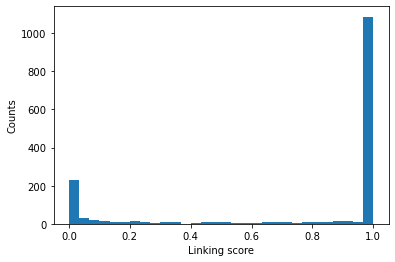

In [5]:
# Unweighted
plt.hist(links_mag["link_score"], bins=30)
plt.ylabel('Counts')
plt.xlabel('Linking score')

Text(0.5, 0, 'Linking score')

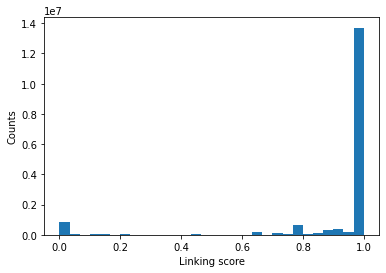

In [6]:
# Weighted by publication count
plt.hist(links_mag["link_score"], bins=30, weights=links_mag["PublicationCount"])
plt.ylabel('Counts')
plt.xlabel('Linking score')


## Inspect links with low scores
- The linking score may be low, but the lat-lon matching seems to work pretty well. So we can allow for a relatively low threshold

In [7]:
mask_keep_links_mag = links_mag["link_score"] > min_score_mag
links_mag = links_mag.loc[mask_keep_links_mag, :]

links_mag.shape
n_linked = links_mag.loc[:, "unitid"].nunique()
print(f"Have linked {n_linked} entities in cng with min score of {min_score_mag}.")



Have linked 1189 entities in cng with min score of 0.6.


In [8]:
sel_vars = ["link_score", "name_mag", "name_cng", 
            "lat_mag", "lon_mag", "lat_cng", "lon_cng"]
links_mag.loc[:, sel_vars].sort_values("link_score").head(10)



,link_score,name_mag,name_cng,lat_mag,lon_mag,lat_cng,lon_cng
118,0.605648,elmhurst college,elmhurst university,41.896310,-87.946170,41.896999,-87.941002
117,0.608186,bank street college of education,king s college,40.805560,-73.966390,40.799000,-73.967003
116,0.609187,the citadel the military college of south caro...,citadel military college of south carolina,32.797220,-79.961110,32.710999,-79.953003
115,0.624554,university of tennessee at chattanooga,university of tennessee chattanooga,35.045800,-85.299900,35.029999,-85.146004
114,0.627106,hunter college,cuny hunter college,40.768540,-73.964745,40.799000,-73.967003
113,0.627285,queens college,cuny queens college,40.737000,-73.817000,40.751999,-73.851997
112,0.636284,wheeling jesuit university,wheeling university,40.073074,-80.689530,40.070000,-80.647003
111,0.641305,st joseph s college,st joseph s university new york,40.690830,-73.968060,40.713001,-73.953003
110,0.652054,salem international university,salem university,39.282780,-80.558060,39.286999,-80.564003
109,0.654997,university of illinois at chicago,university of illinois chicago,41.871887,-87.649250,41.776001,-87.710999


## Group-wise summary of linking status

### MAG entities

Text(0.5, 0, 'Linking status')

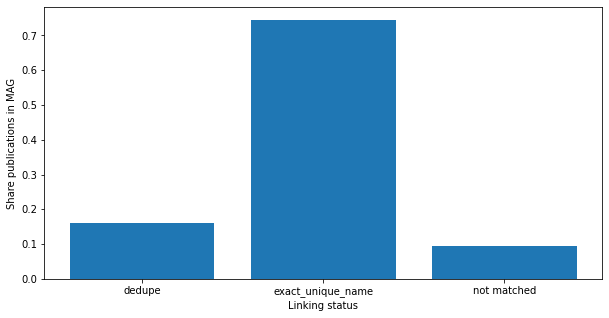

In [9]:
mag_summary = (mag
                .set_index("AffiliationId")
                .join(links_mag
                        .loc[:, ["from_id", "link_flag"]]
                        .set_index("from_id"))
                .reset_index()
                .rename(columns={"index": "AffiliationId"})
            )
mask = mag_summary["link_flag"].isna()
mag_summary["link_flag"] = np.where(mask, "not matched", mag_summary["link_flag"])
mag_summary.head()

mag_summary = (mag_summary
                .groupby("link_flag")["PublicationCount"]
                .sum()
                .reset_index()
                )
mag_summary["id"] = 0
mag_summary["share"] = mag_summary["PublicationCount"] / mag_summary.groupby("id")["PublicationCount"].transform("sum")


fig = plt.figure(figsize = (10, 5))
plt.bar(mag_summary["link_flag"], mag_summary["share"])
plt.ylabel('Share publications in MAG')
plt.xlabel('Linking status')


### CNG entities

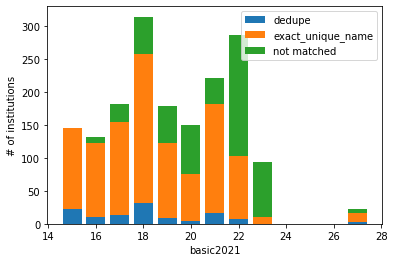

In [10]:
cng_summary = (cng
                .loc[:, ["unitid", "basic2021"]]
                .set_index("unitid")
                .join(links_mag
                        .loc[:, ["unitid", "link_flag"]]
                        .set_index("unitid"))
                .reset_index())


mask = cng_summary["link_flag"].isna()
cng_summary["link_flag"] = np.where(mask, "not matched", cng_summary["link_flag"])
cng_summary = (cng_summary
                .groupby(["basic2021", "link_flag"])
                .count()
                .reset_index()
                .rename(columns={"unitid": "nb"})
                )
cng_summary.head()


index_cols = ["basic2021", "link_flag"]
dict_to_expand = {x: cng_summary[x].unique() for x in index_cols}

def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())


cng_summary = (expand_grid(dict_to_expand)
                .set_index(index_cols)
                .join(cng_summary
                        .set_index(index_cols))
                .reset_index()
                )


mask = cng_summary["nb"].isna()
cng_summary["nb"] = np.where(mask, 0, cng_summary["nb"])


cng_summary["share"] = cng_summary["nb"] / cng_summary.groupby("basic2021")["nb"].transform("sum")


labels = cng_summary["basic2021"].unique()

fig, ax = plt.subplots()

btm = np.zeros(len(labels)) # start at y=0
for x in cng_summary["link_flag"].unique():
        d = cng_summary.loc[cng_summary["link_flag"] == x, "nb"].squeeze()
        d = np.array(d)
        ax.bar(labels, d, label=x, bottom=btm)
        btm += d # progressively add bottom for next bar

ax.set_xlabel("basic2021")
ax.set_ylabel("# of institutions")

ax.legend()

plt.show()

## Non-linked entities

### MAG, by decreasing publication count

In [11]:
mag.head()
mask = (~mag["AffiliationId"].isin(links_mag.from_id)) \
            & (mag.name.str.contains("university|college")) \
            & (~mag.name.str.contains("medical|medicine|health|hospital|cancer"))

sel_vars = ["name", "PublicationCount"]
display(mag.loc[mask, sel_vars].sort_values("PublicationCount", ascending=False).iloc[0:10])


,name,PublicationCount
123,university of california,30791
651,university of hawaii,30271
293,georgia regents university,28840
1282,northeast normal university,18596
1792,national taipei university of technology,12840
218,sewanee the university of the south,12791
327,florida state university college of arts and s...,11375
247,california state university,10612
598,augsburg college,10471
518,humboldt state university,9866


### CNG, by increasing basic2021

In [12]:
mask = (~cng["unitid"].isin(links_mag["unitid"]))
cng.loc[mask, :].sort_values("basic2021").iloc[10:20, :].head()

sel_vars = ["name", "basic2021"]
cng.loc[mask, sel_vars].sort_values("basic2021").iloc[0:10]

,name,basic2021
1068,teachers college at columbia university,16
1454,university of texas rio grande valley,16
972,rutgers university newark,16
1070,new school,16
879,north carolina a t state university,16
341,augusta university,16
955,rutgers university camden,16
317,florida agricultural and mechanical university,16
838,belhaven university,17
1549,university of lynchburg,17


# ProQuest to CNG

In [13]:
pq = (pq
        .set_index("university_id")
        .join(pq_graduate_counts
                .set_index("university_id"))
        .reset_index()
        .rename(columns={"index": "university_id"}))

pq = pq.loc[~pq.n_graduates.isna()]


In [14]:
links_pq = (links
        .loc[links["from_dataset"] == "pq"]
        .set_index("from_id")
        .join(pq.loc[:, ["university_id", "name", "location", "n_graduates"]]
            .set_index("university_id")
        )
        .reset_index()
        .rename(columns={"index": "from_id"})
        .set_index(["unitid"])
        .join(cng.loc[:, ["unitid", "name", "basic2021", "lat", "lon"]]
            .set_index("unitid"),
            lsuffix="_pq", rsuffix="_cng"
        )
        .reset_index()
    )



## Histogram of links


Text(0.5, 0, 'Linking score')

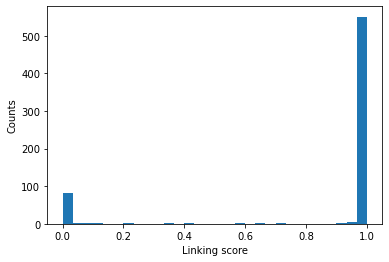

In [15]:
plt.hist(links_pq["link_score"], bins=30) 
plt.ylabel('Counts')
plt.xlabel('Linking score')

In [16]:
mask_keep_links_pq = links_pq["link_score"] > min_score_pq

links_pq = links_pq.loc[mask_keep_links_pq, :]

n_linked = links_pq.from_id.nunique()

print(f"Have linked {n_linked} entities in cng with min score of {min_score_pq}.")



Have linked 561 entities in cng with min score of 0.3.


## Number of theses by linking approach

Text(0.5, 0, 'Linking status')

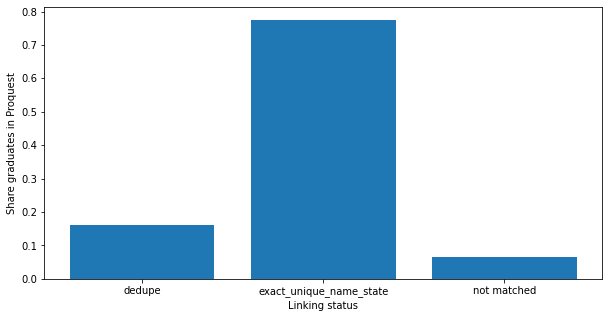

In [17]:
pq_summary = (pq
                .set_index("university_id")
                .join(links_pq 
                        .loc[:, ["from_id", "link_flag"]]
                        .set_index("from_id"))
                .reset_index()
                .rename(columns={"index": "university_id"}))

pq_summary.loc[pq_summary.link_flag.isna()].head()


mask_notlinked = pq_summary["link_flag"].isna()
pq_summary["link_flag"] = np.where(mask_notlinked, "not matched", pq_summary["link_flag"])


pq_summary = (pq_summary
                .groupby("link_flag")["n_graduates"]
                .sum()
                .reset_index()
                )
pq_summary["id"] = 0
pq_summary["share"] = pq_summary["n_graduates"] / pq_summary.groupby("id")["n_graduates"].transform("sum")


fig = plt.figure(figsize = (10, 5))
plt.bar(pq_summary["link_flag"], pq_summary["share"])
plt.ylabel('Share graduates in Proquest')
plt.xlabel('Linking status')



## Investigate non-links

### CNG

In [18]:

mask = (~cng["unitid"].isin(links_pq.loc[:, "unitid"])) \
        & (cng["unitid"].isin(links_mag.loc[:, "unitid"])) # TODO: unified usage of "mask_keep_links" etc! 

sel_vars = ["name", "basic2021"]
cng.loc[mask, sel_vars].sort_values("basic2021").iloc[0:10]


,name,basic2021
1320,west chester university of pennsylvania,16
1105,suny college of environmental science and fore...,16
355,kennesaw state university,16
1510,university of texas at tyler,16
698,university of new england,16
524,valparaiso university,17
113,northcentral university,17
872,elon university,17
1108,russell sage college,17
507,university of indianapolis,17


### Proquest

In [19]:

sel_vars = ["name", "n_graduates"]
(pq
.loc[~pq.university_id.isin(links_pq.loc[:, "from_id"]), sel_vars]
.sort_values("n_graduates", ascending=False)
.iloc[0:10])
                


,name,n_graduates
21,northcentral university,6477.0
662,teachers college columbia university,5141.0
294,chicago school of professional psychology,4569.0
120,alliant international university,3646.0
647,polytechnic university,2673.0
47,united states international university,2509.0
384,southern baptist theological seminary,2038.0
295,university of illinois at chicago health scien...,1886.0
93,pacifica graduate institute,1632.0
57,wright institute,1587.0


# Appendix: investigate Rutgers, CUNY, SUNY

In [20]:
search_name = "rutgers"

for d in [mag, cng, pq]:
    display(d.loc[d["name"].str.contains(search_name), "name"].unique())



array(['rutgers university'], dtype=object)

array(['rutgers university camden', 'rutgers university new brunswick',
       'rutgers university newark'], dtype=object)

array(['rutgers university'], dtype=object)

In [21]:
search_name = "state university of new york"

for d in [mag, cng, pq]:
    display(d.loc[d["name"].str.contains(search_name), "name"].unique())


array(['state university of new york at oswego',
       'state university of new york college of environmental science and forestry',
       'state university of new york at brockport',
       'state university of new york at cortland',
       'state university of new york college of optometry',
       'state university of new york system',
       'state university of new york polytechnic institute',
       'state university of new york at geneseo',
       'state university of new york at new paltz',
       'state university of new york upstate medical university',
       'state university of new york at old westbury',
       'state university of new york at plattsburgh',
       'state university of new york at fredonia',
       'state university of new york at potsdam',
       'state university of new york at purchase',
       'state university of new york at oneonta'], dtype=object)

array(['state university of new york system',
       'state university of new york at new paltz'], dtype=object)

array(['state university of new york system'], dtype=object)

In [22]:
search_name = "city university of new york"

for d in [mag, cng, pq]:
    display(d.loc[d["name"].str.contains(search_name), "name"].unique())


array(['york college city university of new york',
       'city university of new york'], dtype=object)

array(['city university of new york'], dtype=object)

array(['city university of new york'], dtype=object)

In [23]:
print("Done.")

Done.
